<a href="https://colab.research.google.com/github/edumntg/Portfolio/blob/main/Solar_Radiation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solar radiation prediction using ML
### In this notebook, a machine learning model is developed to predict solar radiation for a given day, using temperature, pressure, humidity, wind direction, wind velocity, etc.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

## Load Data

In [46]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


# Feature Engineering

### Split the Time of Sunrise and Time of Sunset into hour and minute

In [25]:
df['Sunrise Hour'] = pd.to_datetime(df['TimeSunRise']).dt.hour
df['Sunrise Minute'] = pd.to_datetime(df['TimeSunRise']).dt.minute

df['Sunset Hour'] = pd.to_datetime(df['TimeSunSet']).dt.hour
df['Sunset Minute'] = pd.to_datetime(df['TimeSunSet']).dt.minute

### Split the Date column into month, day, hour and minute

In [26]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute

### Convert Wind Direction from [0,360] to [-180,180]

In [27]:
df['WindDirection(Degrees)'] -= 180.0

### Describe

In [28]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sunrise Hour,Sunrise Minute,Sunset Hour,Sunset Minute,Month,Day,Hour,Minute
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,-36.510179,6.243869,6.0,27.640519,17.347886,37.317904,10.526066,15.825766,11.557425,27.556691
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.0,15.518714,0.476307,15.938416,1.096691,8.711824,6.912034,17.268507
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,-179.910000,0.000000,6.0,7.000000,17.000000,0.000000,9.000000,1.000000,0.000000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,-97.772500,3.370000,6.0,14.000000,17.000000,26.000000,10.000000,9.000000,6.000000,15.000000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,-32.300000,5.620000,6.0,24.000000,17.000000,43.000000,11.000000,16.000000,12.000000,30.000000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,-0.690000,7.870000,6.0,40.000000,18.000000,48.000000,11.000000,23.000000,18.000000,45.000000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,179.950000,40.500000,6.0,57.000000,18.000000,59.000000,12.000000,31.000000,23.000000,57.000000


### We see that the Sunrise Hour is always equal to six and constant, so this value won't affect the outcome. We will remove this column

In [29]:
df = df.drop(columns = ['UNIXTime', 'Data', 'Time', 'Sunrise Hour', 'TimeSunRise', 'TimeSunSet'])
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sunrise Minute,Sunset Hour,Sunset Minute,Month,Day,Hour,Minute
0,1.21,48,30.46,59,-2.61,5.62,13,18,13,9,29,23,55
1,1.21,48,30.46,58,-3.22,3.37,13,18,13,9,29,23,50
2,1.23,48,30.46,57,-21.25,3.37,13,18,13,9,29,23,45
3,1.21,48,30.46,60,-42.29,3.37,13,18,13,9,29,23,40
4,1.17,48,30.46,62,-75.05,5.62,13,18,13,9,29,23,35


### Split into X and y and then into training and testing

In [30]:
y = df['Radiation'].to_numpy()
X = df.drop(columns = ['Radiation']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

### Scale all columns

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### From the testing dataset, we will take 10% for predictions

In [32]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.1)

_________________________

In [33]:
models = {}
histories = {}

# Model I: XGBoost

In [34]:
model = XGBRegressor(n_estimators=1000, learning_rate = 5E-2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

models['XGBoost'] = model

[18:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
50.398014882439476


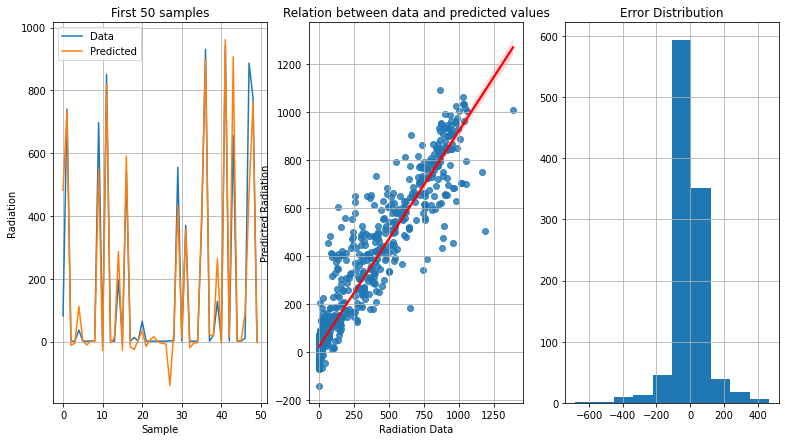

In [55]:
y_pred = models['XGBoost'].predict(X_test)

abs_error = y_test-y_pred

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(13,7))
ax[0].plot(y_test[:50], label = 'Data')
ax[0].plot(y_pred[:50], label = 'Predicted')
ax[0].grid(True)
ax[0].set_ylabel('Radiation')
ax[0].set_xlabel('Sample')
ax[0].set_title('First 50 samples')
ax[0].legend()

# ax[1].plot(y_test, y_pred, 'bo')
# ax[1].grid(True)
sns.regplot(x = y_test, y = y_pred, line_kws = {'color':'red'}, ax=ax[1])
ax[1].grid(True)
ax[1].set_xlabel('Radiation Data')
ax[1].set_ylabel('Predicted Radiation')
ax[1].set_title('Relation between data and predicted values')

ax[2].hist(abs_error)
ax[2].set_title('Error Distribution')
ax[2].grid(True)

plt.show()



# Model II: DL Model

In [36]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(optimizer = 'sgd', loss = 'mae', metrics = ['mse'])

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 200, batch_size = 16)
models['DL'] = model
histories['DL'] = history

Epoch 1/200
1369/1369 [==============================] - 4s 3ms/step - loss: 104.8753 - mse: 45907.6523 - val_loss: 120.9704 - val_mse: 53351.7578
Epoch 2/200
1369/1369 [==============================] - 3s 2ms/step - loss: 73.3264 - mse: 21222.7676 - val_loss: 80.5202 - val_mse: 24965.1582
Epoch 3/200
1369/1369 [==============================] - 3s 2ms/step - loss: 67.7657 - mse: 18638.0156 - val_loss: 59.3562 - val_mse: 15315.3721
Epoch 4/200
1369/1369 [==============================] - 3s 2ms/step - loss: 65.0325 - mse: 17501.3340 - val_loss: 65.2976 - val_mse: 17489.0098
Epoch 5/200
1369/1369 [==============================] - 3s 2ms/step - loss: 62.5405 - mse: 16611.3242 - val_loss: 58.5724 - val_mse: 15017.5176
Epoch 6/200
1369/1369 [==============================] - 3s 2ms/step - loss: 60.2059 - mse: 15414.9609 - val_loss: 82.9570 - val_mse: 25868.6953
Epoch 7/200
1369/1369 [==============================] - 3s 2ms/step - loss: 58.4253 - mse: 14761.1836 - val_loss: 68.9499 - val

In [61]:
y_test.shape

(1079,)

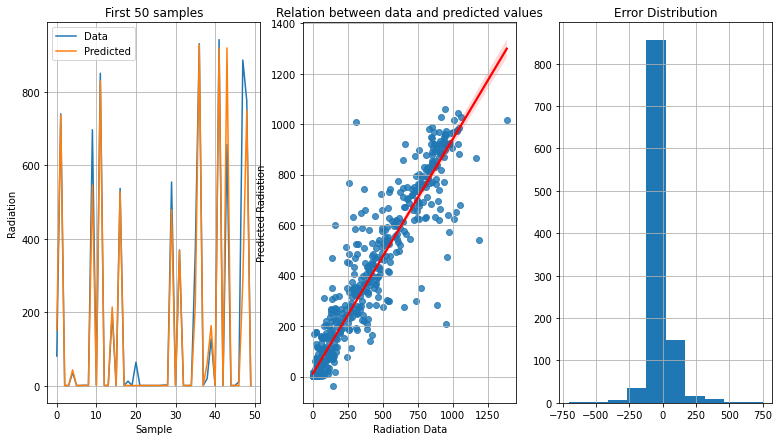

In [63]:
y_pred = models['DL'].predict(X_test)

abs_error = np.expand_dims(y_test, axis=-1)-y_pred

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(13,7))
ax[0].plot(y_test[:50], label = 'Data')
ax[0].plot(y_pred[:50], label = 'Predicted')
ax[0].grid(True)
ax[0].set_ylabel('Radiation')
ax[0].set_xlabel('Sample')
ax[0].set_title('First 50 samples')
ax[0].legend()

# ax[1].plot(y_test, y_pred, 'bo')
# ax[1].grid(True)
sns.regplot(x = y_test, y = y_pred, line_kws = {'color':'red'}, ax=ax[1])
ax[1].grid(True)
ax[1].set_xlabel('Radiation Data')
ax[1].set_ylabel('Predicted Radiation')
ax[1].set_title('Relation between data and predicted values')

ax[2].hist(abs_error)
ax[2].set_title('Error Distribution')
ax[2].grid(True)

plt.show()



# Model III: RNN Model

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
    ])

model.compile(optimizer = 'sgd', loss = 'mae', metrics = ['mse'])

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 200, batch_size = 128)
models['RNN'] = model
histories['RNN'] = history

Epoch 1/200
172/172 [==============================] - 41s 177ms/step - loss: 206.2805 - mse: 141961.9062 - val_loss: 206.4848 - val_mse: 143288.4531
Epoch 2/200
172/172 [==============================] - 29s 170ms/step - loss: 206.0718 - mse: 141521.9375 - val_loss: 206.4756 - val_mse: 143156.1562
Epoch 3/200
172/172 [==============================] - 28s 163ms/step - loss: 206.0623 - mse: 141450.5938 - val_loss: 206.4648 - val_mse: 143195.2812
Epoch 4/200
172/172 [==============================] - 28s 162ms/step - loss: 206.0483 - mse: 141451.9062 - val_loss: 206.4433 - val_mse: 143119.4531
Epoch 5/200
172/172 [==============================] - 28s 162ms/step - loss: 206.0110 - mse: 141409.5781 - val_loss: 206.3736 - val_mse: 143071.7969
Epoch 6/200
172/172 [==============================] - 29s 170ms/step - loss: 205.8030 - mse: 141032.8750 - val_loss: 205.9536 - val_mse: 142404.0469
Epoch 7/200
172/172 [==============================] - 28s 162ms/step - loss: 182.4056 - mse: 110530

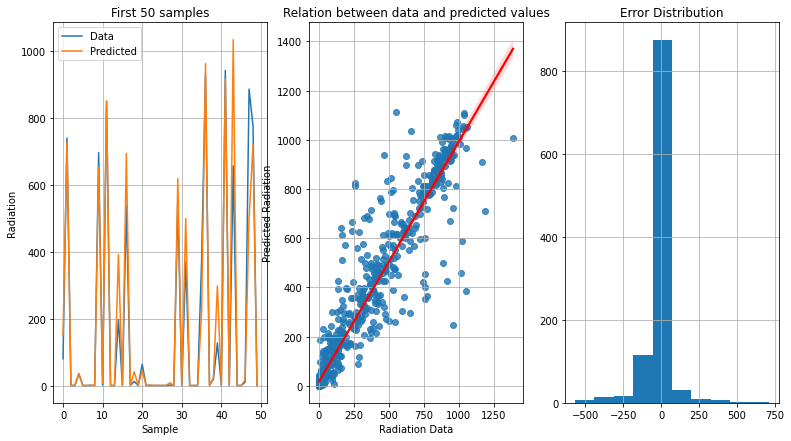

In [64]:
y_pred = models['RNN'].predict(X_test)

abs_error = np.expand_dims(y_test, axis=-1)-y_pred

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(13,7))
ax[0].plot(y_test[:50], label = 'Data')
ax[0].plot(y_pred[:50], label = 'Predicted')
ax[0].grid(True)
ax[0].set_ylabel('Radiation')
ax[0].set_xlabel('Sample')
ax[0].set_title('First 50 samples')
ax[0].legend()

# ax[1].plot(y_test, y_pred, 'bo')
# ax[1].grid(True)
sns.regplot(x = y_test, y = y_pred, line_kws = {'color':'red'}, ax=ax[1])
ax[1].grid(True)
ax[1].set_xlabel('Radiation Data')
ax[1].set_ylabel('Predicted Radiation')
ax[1].set_title('Relation between data and predicted values')

ax[2].hist(abs_error)
ax[2].set_title('Error Distribution')
ax[2].grid(True)

plt.show()



# Model IV: Convolutional NN

### First, reshape the data. Convolutional layers accepts data with 3 dimensions so we have to increase the dimension of the data by 1

In [40]:
X_train2 = np.expand_dims(X_train, axis=-1)
X_test2 = np.expand_dims(X_test, axis=-1)
X_val2 = np.expand_dims(X_val, axis=-1)

In [41]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(128, 2, activation = 'relu', input_shape = (X_train.shape[1],1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model.add(tf.keras.layers.Conv1D(64, 2, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))


model.compile(optimizer = 'sgd', loss = 'mae', metrics = ['mse'])

history = model.fit(X_train2, y_train, validation_data = (X_val2, y_val), epochs = 200, batch_size = 64)

models['CNN'] = model
histories['CNN'] = history

Epoch 1/200
343/343 [==============================] - 3s 7ms/step - loss: 137.0690 - mse: 68493.9219 - val_loss: 184.2155 - val_mse: 94663.1719
Epoch 2/200
343/343 [==============================] - 2s 7ms/step - loss: 88.4206 - mse: 27925.9355 - val_loss: 210.8608 - val_mse: 112755.6562
Epoch 3/200
343/343 [==============================] - 2s 7ms/step - loss: 79.7498 - mse: 23578.7285 - val_loss: 104.5589 - val_mse: 39794.0117
Epoch 4/200
343/343 [==============================] - 3s 8ms/step - loss: 76.4047 - mse: 21780.8203 - val_loss: 86.9418 - val_mse: 29123.4277
Epoch 5/200
343/343 [==============================] - 2s 7ms/step - loss: 72.1233 - mse: 19564.8281 - val_loss: 142.5858 - val_mse: 56393.9609
Epoch 6/200
343/343 [==============================] - 2s 7ms/step - loss: 68.9484 - mse: 18257.1367 - val_loss: 68.3157 - val_mse: 18851.5449
Epoch 7/200
343/343 [==============================] - 2s 7ms/step - loss: 67.2114 - mse: 17489.3730 - val_loss: 127.8728 - val_mse: 535

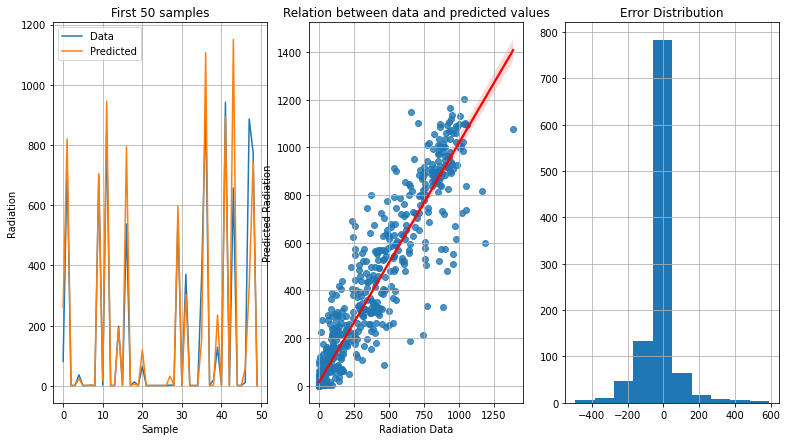

In [65]:
y_pred = models['CNN'].predict(X_test)

abs_error = np.expand_dims(y_test, axis=-1)-y_pred

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(13,7))
ax[0].plot(y_test[:50], label = 'Data')
ax[0].plot(y_pred[:50], label = 'Predicted')
ax[0].grid(True)
ax[0].set_ylabel('Radiation')
ax[0].set_xlabel('Sample')
ax[0].set_title('First 50 samples')
ax[0].legend()

# ax[1].plot(y_test, y_pred, 'bo')
# ax[1].grid(True)
sns.regplot(x = y_test, y = y_pred, line_kws = {'color':'red'}, ax=ax[1])
ax[1].grid(True)
ax[1].set_xlabel('Radiation Data')
ax[1].set_ylabel('Predicted Radiation')
ax[1].set_title('Relation between data and predicted values')

ax[2].hist(abs_error)
ax[2].set_title('Error Distribution')
ax[2].grid(True)

plt.show()



##Plot losses

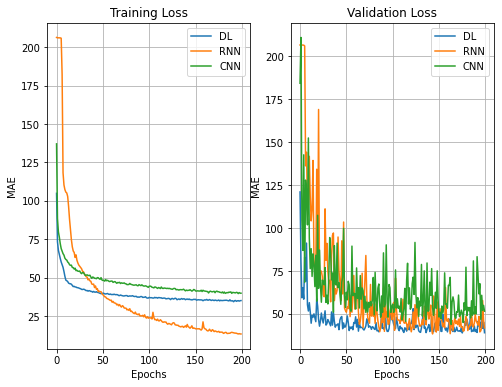

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(8,6))

for name, history in histories.items():
  ax[0].plot(history.history['loss'], label = name)
  ax[1].plot(history.history['val_loss'], label = name)


#plt.plot(history1.history['loss'], label = 'Base')
#plt.plot(history2.history['loss'], label = 'CNN')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[0].set_title('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE')
ax[1].set_title('Validation Loss')
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.show()